In [1]:
import pandas as pd
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 10)
import requests
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import folium
from geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt

In [2]:
# Import the data of toronto nieghborhood coordinators from csv sheet
toronto_niegh_df = pd.read_csv('toronto_niegh.csv')
toronto_niegh_df.tail()

,Unnamed: 0,Postal_Code,Borough,Neighbourhood,latitude,longitude
98,98,M9N,York,Weston,43.7068,-79.5170
99,99,M9P,Etobicoke,Westmount,43.6949,-79.5323
100,100,M9R,Etobicoke,"Kingsview Village, St. Phillips, Martin Grove ...",43.6898,-79.5582
101,101,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest...",43.7432,-79.5876
102,102,M9W,Etobicoke,"Northwest, West Humber - Clairville",43.7144,-79.5909


Merging the Borough and neighborhood columns <br>
rename neighborhood to Borough_Neighbourhood <br>
Remove the postal code column as we don't need it

In [3]:
toronto_niegh_df = toronto_niegh_df.groupby(['Postal_Code','Borough','latitude','longitude'])['Neighbourhood'].agg(lambda x: ','.join(x)).reset_index()
toronto_niegh_df['Neighbourhood'] = toronto_niegh_df['Borough'] +'/' + toronto_niegh_df['Neighbourhood']
cols = ['Postal_Code','Neighbourhood', 'latitude', 'longitude']
toronto_niegh_df = toronto_niegh_df[cols]
toronto_niegh_df.rename(columns={'Neighbourhood': 'Borough_Neighbourhood'},inplace=True)
toronto_niegh_df

,Postal_Code,Borough_Neighbourhood,latitude,longitude
0,M1B,"Scarborough/Malvern, Rouge",43.8113,-79.1930
1,M1C,"Scarborough/Rouge Hill, Port Union, Highland C...",43.7878,-79.1564
2,M1E,"Scarborough/Guildwood, Morningside, West Hill",43.7678,-79.1866
3,M1G,Scarborough/Woburn,43.7712,-79.2144
4,M1H,Scarborough/Cedarbrae,43.7686,-79.2389
...,...,...,...,...
98,M9N,York/Weston,43.7068,-79.5170
99,M9P,Etobicoke/Westmount,43.6949,-79.5323
100,M9R,"Etobicoke/Kingsview Village, St. Phillips, Mar...",43.6898,-79.5582
101,M9V,"Etobicoke/South Steeles, Silverstone, Humberga...",43.7432,-79.5876


Create Foursquare credentails (ClientId, SecretId) <br>
Set the defualt values for limit and radius for Foursquare API's

In [4]:
CLIENT_ID = 'RPXJ5NIXD2LVQ2OCHIYFV2E0J5J5YV1F0IRIUJJSAFKOGEPE' # your Foursquare ID
CLIENT_SECRET = 'VRZ5CQU3VMNKODQD3KEJMC4RZKYD2PWHZX5M5GSTDH040TQ1' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
radius = 5000

Get the avaliable venues for each neighborhood, please note we can retrive up to 100 venues for each <br>
neighborhood becuase we use free foursquare account

In [5]:
# Get the avaliable venues for each nieghborhood:

# intilize the varaibles
toronto_list = []
for i, row in toronto_niegh_df.iterrows():
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        row.latitude,
        row.longitude,
        radius,
        LIMIT)
    results = requests.get(url).json()
    try:
        venue_list = results['response']['groups'][0]['items']
        for index, item in enumerate(venue_list):
            venue_cat = item['venue']['categories'][0]['name']
            venue_id = item['venue']['id']
            toronto_list.append([row.Borough_Neighbourhood,row.latitude,row.longitude,venue_id,venue_cat])
            toronto_venues = pd.DataFrame(toronto_list)
            toronto_venues.columns = ['Borough_Neighbourhood','Neighborhood_Latitude','Neighborhood_Longitude','Venue_Id','Venue_Cat']
    except KeyError:
        continue
            
toronto_venues          

,Borough_Neighbourhood,Neighborhood_Latitude,Neighborhood_Longitude,Venue_Id,Venue_Cat
0,"Scarborough/Malvern, Rouge",43.8113,-79.1930,4cd854fd3ec4b1f71900be3f,Zoo Exhibit
1,"Scarborough/Malvern, Rouge",43.8113,-79.1930,4ad4c05ef964a52093f620e3,Zoo
2,"Scarborough/Malvern, Rouge",43.8113,-79.1930,4bf590095e800f47b1b8e5d4,Zoo
3,"Scarborough/Malvern, Rouge",43.8113,-79.1930,542858a0498e22b7cfa91070,Athletics & Sports
4,"Scarborough/Malvern, Rouge",43.8113,-79.1930,50730879e4b00022a2a53d29,Zoo Exhibit
...,...,...,...,...,...
10292,"Etobicoke/Northwest, West Humber - Clairville",43.7144,-79.5909,5bdbe3cec66666002c59d26e,Coffee Shop
10293,"Etobicoke/Northwest, West Humber - Clairville",43.7144,-79.5909,4bd4c5f5637ba5938470f570,Restaurant
10294,"Etobicoke/Northwest, West Humber - Clairville",43.7144,-79.5909,4dcdab65c65bdac7134dd434,Sporting Goods Shop
10295,"Etobicoke/Northwest, West Humber - Clairville",43.7144,-79.5909,4bfb040dab180f47934ab3ce,Ice Cream Shop


Filter the restaurants

In [6]:
# filtering the resturant records
toronto_restu = toronto_venues.loc[toronto_venues['Venue_Cat'].str.contains('Restaurant')]
print(toronto_restu.shape)
toronto_restu.head()

(2353, 5)


,Borough_Neighbourhood,Neighborhood_Latitude,Neighborhood_Longitude,Venue_Id,Venue_Cat
17,"Scarborough/Malvern, Rouge",43.8113,-79.193,4bccf9bf511f9521ce0eb4c7,Italian Restaurant
18,"Scarborough/Malvern, Rouge",43.8113,-79.193,4b6718c2f964a5203f3a2be3,Restaurant
31,"Scarborough/Malvern, Rouge",43.8113,-79.193,4b340050f964a520b42325e3,Restaurant
49,"Scarborough/Malvern, Rouge",43.8113,-79.193,4b914562f964a520d4ae33e3,Caribbean Restaurant
53,"Scarborough/Malvern, Rouge",43.8113,-79.193,4bf025afc8d920a1bd799430,Chinese Restaurant


In [7]:
# saving DF into CSV file
# toronto_restu.to_csv(r'C:\Users\stum2013148992\toronto_restu.csv')

In [8]:
# Merging the categories for different resturants for each nieghborhood
toronto_grouped = toronto_restu.groupby(['Borough_Neighbourhood','Neighborhood_Latitude','Neighborhood_Longitude'])['Venue_Cat'].agg(lambda x: ','.join(x)).reset_index()
toronto_grouped

,Borough_Neighbourhood,Neighborhood_Latitude,Neighborhood_Longitude,Venue_Cat
0,Central Toronto/Davisville,43.7020,-79.3853,"Italian Restaurant,Indian Restaurant,Italian R..."
1,Central Toronto/Davisville North,43.7135,-79.3887,"Italian Restaurant,Italian Restaurant,Italian ..."
2,"Central Toronto/Forest Hill North & West, Fore...",43.6966,-79.4120,"Italian Restaurant,Indian Restaurant,Italian R..."
3,Central Toronto/Lawrence Park,43.7301,-79.3935,"Japanese Restaurant,French Restaurant,Fast Foo..."
4,"Central Toronto/Moore Park, Summerhill East",43.6899,-79.3853,"Sushi Restaurant,Italian Restaurant,Italian Re..."
...,...,...,...,...
98,York/Caledonia-Fairbanks,43.6889,-79.4507,"Japanese Restaurant,Italian Restaurant,Caribbe..."
99,"York/Del Ray, Mount Dennis, Keelsdale and Silv...",43.6934,-79.4857,"Italian Restaurant,Japanese Restaurant,Restaur..."
100,York/Humewood-Cedarvale,43.6915,-79.4307,"Indian Restaurant,Caribbean Restaurant,Italian..."
101,"York/Runnymede, The Junction North",43.6748,-79.4839,"Italian Restaurant,Italian Restaurant,Seafood ..."


In [9]:
# There are many dupplicated restaurants categories,So let us remove the ducplicated one's and count the number of unique categories for each nieghborhood 
toronto_grouped['Venue_Cat'][0]

'Italian Restaurant,Indian Restaurant,Italian Restaurant,Ramen Restaurant,Italian Restaurant,Indian Restaurant,Indonesian Restaurant,Restaurant,Italian Restaurant,Vegetarian / Vegan Restaurant,Sushi Restaurant,Italian Restaurant,French Restaurant,Mexican Restaurant,Vegetarian / Vegan Restaurant,Tapas Restaurant,Greek Restaurant,Italian Restaurant,Indian Restaurant'

In [10]:
# Removing the dupplicated categories from Venue_Cat column
s_to_d = {}
for i,row in toronto_grouped.iterrows():
    s_to_d[i] = list(toronto_grouped['Venue_Cat'][i].split(','))
    s_to_d[i] = list(dict.fromkeys(s_to_d[i]))
    
    
s_to_d[0]

['Italian Restaurant',
 'Indian Restaurant',
 'Ramen Restaurant',
 'Indonesian Restaurant',
 'Restaurant',
 'Vegetarian / Vegan Restaurant',
 'Sushi Restaurant',
 'French Restaurant',
 'Mexican Restaurant',
 'Tapas Restaurant',
 'Greek Restaurant']

In [11]:
# Computing the number of unique Resturant types for each Nieghborhood
toronto_grouped['Variety'] = 'NaN'
for i, row in toronto_grouped.iterrows():
    toronto_grouped.at[i,'Variety'] = len(s_to_d[i])

toronto_grouped

,Borough_Neighbourhood,Neighborhood_Latitude,Neighborhood_Longitude,Venue_Cat,Variety
0,Central Toronto/Davisville,43.7020,-79.3853,"Italian Restaurant,Indian Restaurant,Italian R...",11
1,Central Toronto/Davisville North,43.7135,-79.3887,"Italian Restaurant,Italian Restaurant,Italian ...",12
2,"Central Toronto/Forest Hill North & West, Fore...",43.6966,-79.4120,"Italian Restaurant,Indian Restaurant,Italian R...",9
3,Central Toronto/Lawrence Park,43.7301,-79.3935,"Japanese Restaurant,French Restaurant,Fast Foo...",14
4,"Central Toronto/Moore Park, Summerhill East",43.6899,-79.3853,"Sushi Restaurant,Italian Restaurant,Italian Re...",12
...,...,...,...,...,...
98,York/Caledonia-Fairbanks,43.6889,-79.4507,"Japanese Restaurant,Italian Restaurant,Caribbe...",13
99,"York/Del Ray, Mount Dennis, Keelsdale and Silv...",43.6934,-79.4857,"Italian Restaurant,Japanese Restaurant,Restaur...",13
100,York/Humewood-Cedarvale,43.6915,-79.4307,"Indian Restaurant,Caribbean Restaurant,Italian...",15
101,"York/Runnymede, The Junction North",43.6748,-79.4839,"Italian Restaurant,Italian Restaurant,Seafood ...",12


Crating final dataFrame which contains:<br>
1-Number of unique categories of resturants (Column=Variety) <br>
2-Resturants number (Column=Venue_Count)

In [13]:
niegh_df = toronto_restu.groupby(by=['Borough_Neighbourhood','Neighborhood_Latitude','Neighborhood_Longitude']).agg( {'Venue_Cat': lambda x: x.count()}).reset_index()
niegh_df.rename(columns={'Venue_Cat': 'Venue_Count'}, inplace=True)
niegh_df['Variety'] = toronto_grouped['Variety']
niegh_df

,Borough_Neighbourhood,Neighborhood_Latitude,Neighborhood_Longitude,Venue_Count,Variety
0,Central Toronto/Davisville,43.7020,-79.3853,19,11
1,Central Toronto/Davisville North,43.7135,-79.3887,19,12
2,"Central Toronto/Forest Hill North & West, Fore...",43.6966,-79.4120,16,9
3,Central Toronto/Lawrence Park,43.7301,-79.3935,23,14
4,"Central Toronto/Moore Park, Summerhill East",43.6899,-79.3853,20,12
...,...,...,...,...,...
98,York/Caledonia-Fairbanks,43.6889,-79.4507,22,13
99,"York/Del Ray, Mount Dennis, Keelsdale and Silv...",43.6934,-79.4857,28,13
100,York/Humewood-Cedarvale,43.6915,-79.4307,25,15
101,"York/Runnymede, The Junction North",43.6748,-79.4839,22,12


In [14]:
# checking if variations in number of restaurants and thier categories are significant enough to build robust clustering model
print('Maximum Variety: ', niegh_df['Variety'].max(),'Minimum Variety: ',niegh_df['Variety'].min())
print('Maximum Veneu Count:', niegh_df['Venue_Count'].max(), 'Minimum Venue Count:', niegh_df['Venue_Count'].min())

Maximum Variety:  24 Minimum Variety:  7
Maximum Veneu Count: 45 Minimum Venue Count: 10


In [15]:
# (Optional) Saving the final dataframe as CSV file to use it later in building the clustering model
niegh_df.to_csv(r'C:\Users\stum2013148992\niegh_df.csv')

Steps to get the ratings for each venue, its applicable for those who have bussiness subscription with Foursquare and enough quota to runn high number of premium and regualr calls type

In [16]:
# (Step1)Creatging list of urls which will be used to call Foursquare end points
#url_list = []
#for i, row in toronto_restu.iterrows():
    #url_list.append([i,'https://api.foursquare.com/v2/venues/{}?'.format(row.Venue_Id),'client_id={}&client_secret={}&v={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION)])


#url_list[0][2]

In [17]:
#(Step2) Append url_list items to create full urls
#urls = []
#for i,item in enumerate(url_list):
   # index = url_list[i][0]
   # s1 = url_list[i][1]
    #s2 = url_list[i][2]
    #s3 = s1 + s2
    #urls.append([index,s3])

#urls[0][1]

In [18]:
# Step3
#toronto_rating = toronto_restu.copy()
#toronto_rating['Rating'] = np.nan
#toronto_rating

In [19]:
# Step4
#for i,item in enumerate(urls):
    #try:
        #result = requests.get(item[1]).json()
       # toronto_rating.at[item[0], 'Rating'] = result['response'] # full path to rating needs to used
    #except KeyError:
        #continue

#toronto_rating

In [20]:
#Check the readiness if niegh_df dataframe
niegh_df.isna().sum()

Borough_Neighbourhood     0
Neighborhood_Latitude     0
Neighborhood_Longitude    0
Venue_Count               0
Variety                   0
dtype: int64

Data Standarad 

In [22]:
x = niegh_df[['Venue_Count', 'Variety']]
x

,Venue_Count,Variety
0,19,11
1,19,12
2,16,9
3,23,14
4,20,12
...,...,...
98,22,13
99,28,13
100,25,15
101,22,12


In [23]:
x_cluster = StandardScaler().fit_transform(x)
x_cluster[0:10]

array([[-0.43265074, -0.68621859],
       [-0.43265074, -0.43734354],
       [-0.77024942, -1.18396869],
       [ 0.01748084,  0.06040657],
       [-0.32011784, -0.43734354],
       [-0.88278231, -1.68171879],
       [-0.32011784, -0.93509364],
       [-0.32011784, -0.18846849],
       [-1.220381  , -0.43734354],
       [-1.220381  , -1.43284374]])

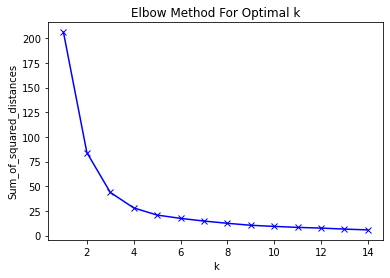

In [25]:
# Calculating the best optimal k by using Elbow method
import matplotlib.pyplot as plt
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(x_cluster)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In the plot above the elbow is at k=3 indicating the optimal k for this dataset is 3

In [26]:
kclusters = 3
k_means = KMeans(init = "k-means++", n_clusters = kclusters, n_init = 12)
k_means.fit(x_cluster)
labels = k_means.labels_
print(labels)

[2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 1 2 1 2 1 1 1 1
 1 1 1 2 1 1 1 1 2 1 2 2 2 1 1 0 2 1 1 1 1 1 1 1 2 0 2 1 1 1 1 0 1 0 1 1 1
 1 0 2 1 0 2 0 1 2 1 2 0 2 1 0 1 0 2 2 1 2 2 2 2 1 1 1 2 2]


In [27]:
# Adding label column to niegh_df DataFrame
niegh_df['label'] = labels
niegh_df.head()

,Borough_Neighbourhood,Neighborhood_Latitude,Neighborhood_Longitude,Venue_Count,Variety,label
0,Central Toronto/Davisville,43.7020,-79.3853,19,11,2
1,Central Toronto/Davisville North,43.7135,-79.3887,19,12,2
2,"Central Toronto/Forest Hill North & West, Fore...",43.6966,-79.4120,16,9,2
3,Central Toronto/Lawrence Park,43.7301,-79.3935,23,14,1
4,"Central Toronto/Moore Park, Summerhill East",43.6899,-79.3853,20,12,2


In [28]:
# check if there is any empty cell
niegh_df.isna().sum()

Borough_Neighbourhood     0
Neighborhood_Latitude     0
Neighborhood_Longitude    0
Venue_Count               0
Variety                   0
label                     0
dtype: int64

Use geopy library to get the latitude and longitude values of Toronto City

In [29]:
address = 'Toronto'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto City are 43.6534817, -79.3839347.


Examine the cluters

In [43]:
#Cluter0:
niegh_df[niegh_df['label'] == 0]

,Borough_Neighbourhood,Neighborhood_Latitude,Neighborhood_Longitude,Venue_Count,Variety,label,Cluster
28,East Toronto/Business reply mail Processing Ce...,43.7804,-79.2505,40,19,0,High density and Variety
52,North York/Bayview Village,43.7797,-79.3813,39,17,0,High density and Variety
62,North York/Hillcrest Village,43.8015,-79.3577,41,19,0,High density and Variety
68,North York/Parkwoods,43.7545,-79.3300,42,21,0,High density and Variety
70,"North York/Willowdale, Newtonbrook",43.7915,-79.4103,39,21,0,High density and Variety
...,...,...,...,...,...,...,...
78,"Scarborough/Clarks Corners, Tam O'Shanter, Sul...",43.7812,-79.3036,45,20,0,High density and Variety
80,"Scarborough/Dorset Park, Wexford Heights, Scar...",43.7612,-79.2707,44,24,0,High density and Variety
85,"Scarborough/Milliken, Agincourt North, Steeles...",43.8177,-79.2819,43,21,0,High density and Variety
88,"Scarborough/Steeles West, L'Amoreaux West",43.8016,-79.3216,44,20,0,High density and Variety


In [44]:
#Cluter1
niegh_df[niegh_df['label'] == 1]

,Borough_Neighbourhood,Neighborhood_Latitude,Neighborhood_Longitude,Venue_Count,Variety,label,Cluster
3,Central Toronto/Lawrence Park,43.7301,-79.3935,23,14,1,Medium density and Variety
29,"East Toronto/India Bazaar, The Beaches West",43.6693,-79.3155,22,17,1,Medium density and Variety
31,East Toronto/The Beaches,43.6784,-79.2941,23,20,1,Medium density and Variety
33,"East York/East Toronto, Broadview North (Old E...",43.6872,-79.3368,22,20,1,Medium density and Variety
34,East York/Leaside,43.7124,-79.3644,20,15,1,Medium density and Variety
...,...,...,...,...,...,...,...
89,Scarborough/Upper Rouge,43.8340,-79.2069,22,13,1,Medium density and Variety
93,"West Toronto/Dufferin, Dovercourt Village",43.6655,-79.4378,24,14,1,Medium density and Variety
98,York/Caledonia-Fairbanks,43.6889,-79.4507,22,13,1,Medium density and Variety
99,"York/Del Ray, Mount Dennis, Keelsdale and Silv...",43.6934,-79.4857,28,13,1,Medium density and Variety


In [45]:
#Cluter2
niegh_df[niegh_df['label'] == 2]

,Borough_Neighbourhood,Neighborhood_Latitude,Neighborhood_Longitude,Venue_Count,Variety,label,Cluster
0,Central Toronto/Davisville,43.7020,-79.3853,19,11,2,Low density and Variety
1,Central Toronto/Davisville North,43.7135,-79.3887,19,12,2,Low density and Variety
2,"Central Toronto/Forest Hill North & West, Fore...",43.6966,-79.4120,16,9,2,Low density and Variety
4,"Central Toronto/Moore Park, Summerhill East",43.6899,-79.3853,20,12,2,Low density and Variety
5,"Central Toronto/North Toronto West, Lawrence Park",43.7143,-79.4065,15,7,2,Low density and Variety
...,...,...,...,...,...,...,...
95,"West Toronto/Little Portugal, Trinity",43.6480,-79.4177,11,7,2,Low density and Variety
96,"West Toronto/Parkdale, Roncesvalles",43.6469,-79.4521,17,11,2,Low density and Variety
97,"West Toronto/Runnymede, Swansea",43.6512,-79.4828,20,12,2,Low density and Variety
101,"York/Runnymede, The Junction North",43.6748,-79.4839,22,12,2,Low density and Variety


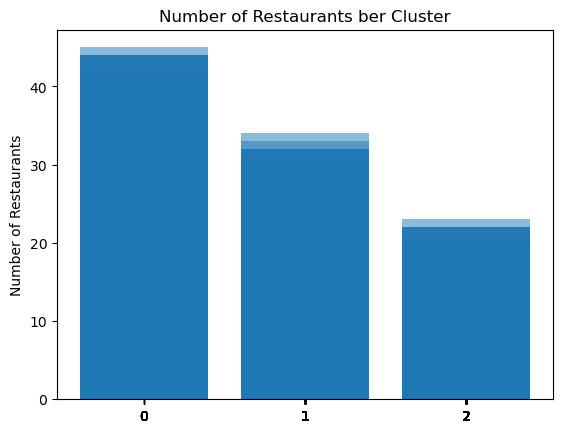

In [39]:
# Visulaize the clusters (Cluster Vs Restaurants Count)
objects = ('0', '1', '2')
y_pos = niegh_df['label']
performance = niegh_df['Venue_Count']
try:
    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.ylabel('Number of Restaurants')
    plt.title('Number of Restaurants ber Cluster')
    plt.xticks(y_pos, objects)
    
except ValueError:
    pass

plt.show()

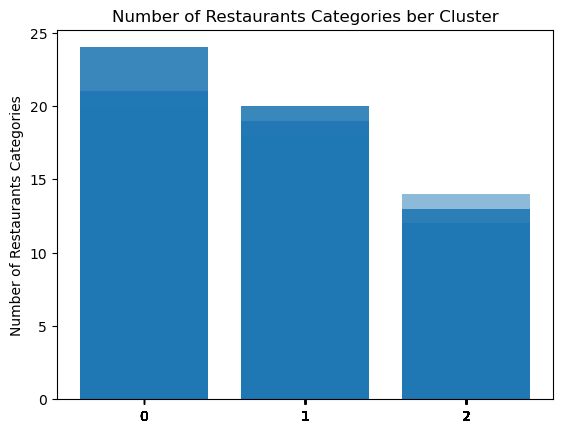

In [34]:
# Visulaize the clusters (Cluster Vs Restaurants Variety)
objects = ('0', '1', '2')
y_pos = niegh_df['label']
performance = niegh_df['Variety']
try:
    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.ylabel('Number of Restaurants Categories')
    plt.title('Number of Restaurants Categories ber Cluster')
    plt.xticks(y_pos, objects)
    
except ValueError:
    pass

plt.show()

Visulaize the Clusters

In [41]:
# Create new column to describe the cluster behaviour 
niegh_df.loc[niegh_df['label'] == 2, 'Cluster'] = 'Low density and Variety' # 1
niegh_df.loc[niegh_df['label'] == 1, 'Cluster'] = 'Medium density and Variety' # 0
niegh_df.loc[niegh_df['label'] == 0, 'Cluster'] = 'High density and Variety' # 2

In [47]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster,clusterNum in zip(niegh_df['Neighborhood_Latitude'], niegh_df['Neighborhood_Longitude'], niegh_df['Borough_Neighbourhood'],niegh_df['Cluster'], niegh_df['label']):
    label = folium.Popup(str(poi) + ' Cluster ' + cluster, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[clusterNum-1],
        fill=True,
        fill_color=rainbow[clusterNum-1],
        fill_opacity=0.7).add_to(map_clusters)
       

link = 'https://kokes.github.io/nbviewer.js/viewer.html#aHR0cHM6Ly9naXRodWIuY29tL2hhbGh3YWRpL0NvdXJzZXJhX0NhcHN0b25lL2Jsb2IvbWFpbi9XZWVrJTIwNCUyMGJhdHRlbCUyMG9mJTIwbmVpZ2hib3Job29kJTIwLSUyMEZpbmFsJTIwQXNzaWdubWVudC5pcHluYg=='
print('Please use the below link to view the map:')
print(link)
map_clusters

Please use the below link to view the map:
https://kokes.github.io/nbviewer.js/viewer.html#aHR0cHM6Ly9naXRodWIuY29tL2hhbGh3YWRpL0NvdXJzZXJhX0NhcHN0b25lL2Jsb2IvbWFpbi9XZWVrJTIwNCUyMGJhdHRlbCUyMG9mJTIwbmVpZ2hib3Job29kJTIwLSUyMEZpbmFsJTIwQXNzaWdubWVudC5pcHluYg==
